In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline as ius
import magnification
import testdata

In [3]:
plt.rcParams['font.family'] = 'serif'# 'sans-serif'
plt.rcParams['font.serif'] = "STIXGeneral"
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rc("text",usetex=True)
plt.rc("font",family="serif")
plt.rc("font",serif="STIXGeneral")

In [4]:
mag = magnification.mag_fft.magnification(profile_names=['disk', 'limb1', 'limb2'])

CPU times: user 4.8 ms, sys: 0 ns, total: 4.8 ms
Wall time: 4.81 ms


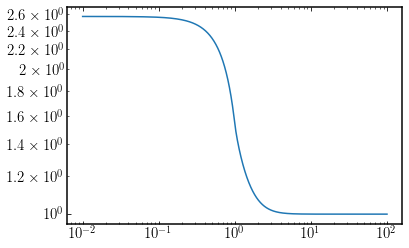

In [5]:
u = np.logspace(-2, 2, 10000)
rho = 1.0
%time a = mag.A_limb1(u, rho)

plt.figure()
plt.loglog(u, a)
plt.show()

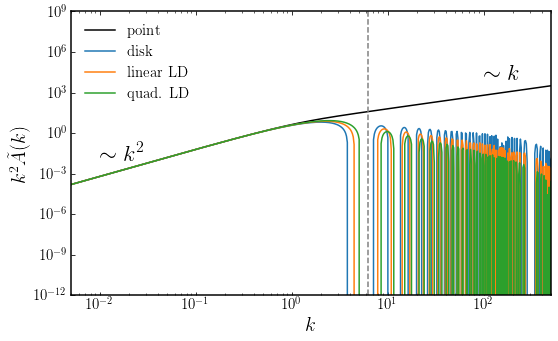

In [7]:
k = mag.k
apk = mag.apk
sk_disk = magnification.mag_fft.sk_disk(k, rho)
sk_limb = magnification.mag_fft.sk_limb(k, rho, 1)
sk_para = magnification.mag_fft.sk_limb(k, rho, 2)
k_rho = 2.0*np.pi/rho
dump = np.exp(-(k/50/k_rho)**2)

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_xlabel(r'$k$', fontsize=20)
ax.set_ylabel(r'$k^2\tilde{A}(k)$', fontsize=20)
ax.set_xlim(5e-3, 5e2)
ax.set_ylim(1e-12,1e9)
ax.loglog(k, k**2*apk, label=r'point', color='k')
ax.loglog(k, k**2*apk*sk_disk*dump, label=r'disk')
ax.loglog(k, k**2*apk*sk_limb*dump, label=r'linear LD')
ax.loglog(k, k**2*apk*sk_para*dump, label=r'quad. LD')
ax.axvline(2*np.pi/rho, color='gray', linestyle='--')
ax.legend(frameon=False)
ax.text(1e2 , 1e4 , r'$\sim k$'  , fontsize=23)
ax.text(1e-2, 1e-2, r'$\sim k^2$', fontsize=23)
plt.tight_layout()
plt.show()

## residual plot

1e-5 1e-05
1e-3 0.001
1e-1 0.1
1 1
1e-5 1e-05
1e-3 0.001
1e-1 0.1
1 1
1e-5 1e-05
1e-3 0.001
1e-1 0.1
1 1


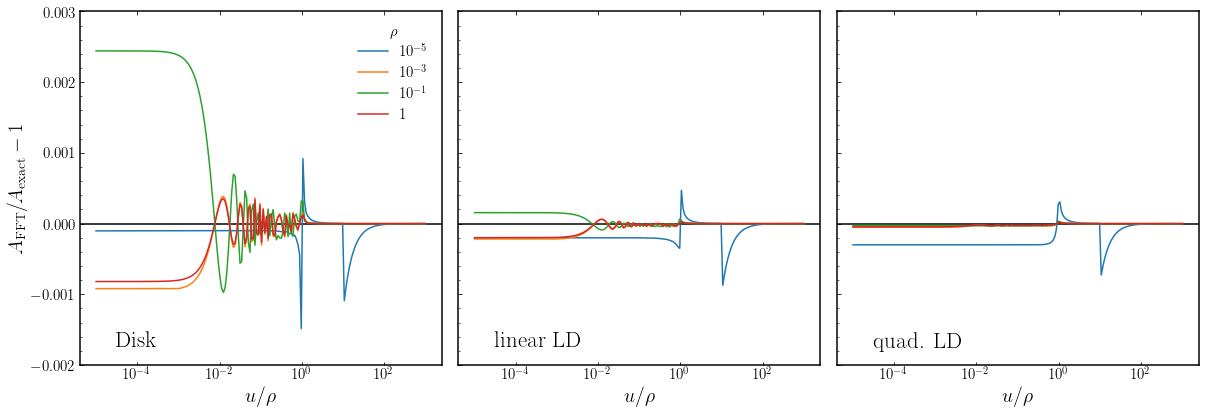

In [8]:
fig, axes = plt.subplots(1,3, figsize=(17,6))
ax = axes[0]
ax.set_ylabel(r'$A_{\rm FFT}/A_{\rm exact}-1$', fontsize=20)

#x = np.logspace(-3, 2.5, 100)
rhos = [1e-5, 1e-3, 1e-1, 1]
labels = [r'$10^{-5}$', r'$10^{-3}$', r'$10^{-1}$', r'$1$']
suffixes = ['1e-5', '1e-3', '1e-1', '1']

fnames = ['disk', 'limb', 'para']
texts = ['Disk', 'linear LD', 'quad. LD']
funcs = [mag.A_disk, mag.A_limb1, mag.A_limb2]
for i, (fname, text, func) in enumerate(zip(fnames, texts, funcs)):
    ax = axes[i]
    ax.axhline(0.0, color='k', linestyle='-')
    ax.set_xlabel(r'$u/\rho$', fontsize=20)

    for rho, label, suffix in zip(rhos, labels, suffixes):
        print(suffix, rho)
        u, _, a_true = testdata.get_test_data('testdata/%s_%s.txt'%(fname, suffix))
        #a_true = ius(u, a, ext=3)(x*rho)
        a_fft = func(u, rho)
        x = u/rho
        ax.semilogx(x, a_fft/a_true-1, label=label)
    ax.text(0.1, 0.05, text, fontsize=23, transform=ax.transAxes)
    
    ax.set_ylim(-2e-3, 3e-3)

    if i==0:
        ax.legend(title=r'$\rho$', frameon=False)
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()

## Residual plot in 2d
Note: Following cells need large test data set, which are not uploaded to github repository.
You can generate the test data set, by activating under line 139 in `testdata.py` and run `python testdata.py`.
You can parallelize the computation using mpi to reduce time. Just use as `mpirun -n 10 python testdata.py`.

In [11]:
residuals = {'disk':[], 'limb':[], 'para':[]}
A  = {'disk':mag.A_disk, 'limb':mag.A_limb1, 'para':mag.A_limb2}

for name in residuals.keys():
    for i in range(100):
        u, rho, a = testdata.get_test_data('testdata2dquads/%s_%d'%(name, i))
        a_fft = A[name](u, rho)
        res = a_fft/a-1
        residuals[name].append(res)
    residuals[name] = np.array(residuals[name])
x = u/rho
rhos = np.logspace(-5, 2, 100)

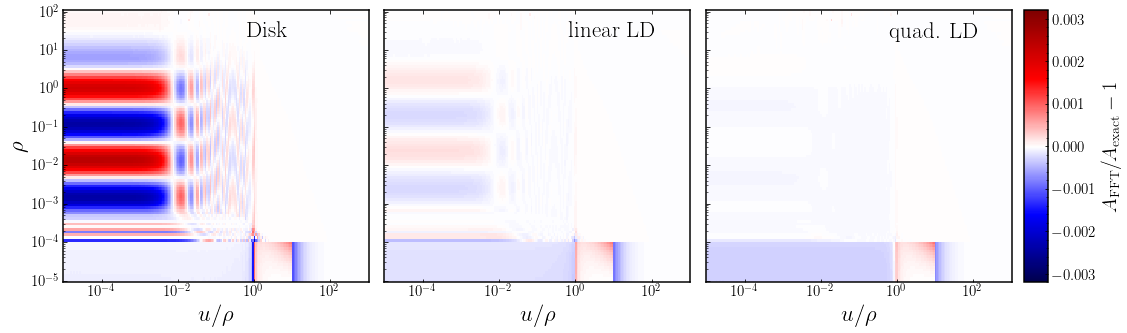

In [12]:
fig, axes = plt.subplots(1,3, figsize=(17,5))
plt.subplots_adjust(wspace=0.05)

texts = ['Disk', 'linear LD', 'quad. LD']
for i, name in enumerate(residuals.keys()):
    ax = axes[i]
    ax.set_xscale('log')
    ax.set_yscale('log')
    im = ax.pcolormesh(x,rhos,residuals[name], cmap='seismic', shading='auto', vmin=-3.2e-3, vmax=3.2e-3)
    if i == 0:
        ax.set_ylabel(r'$\rho$',fontsize=23)
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel(r'$u/\rho$', fontsize=23)
    
    ax.text(0.6, 0.9, texts[i], fontsize=23, transform=ax.transAxes)

axpos = axes[0].get_position()
cbar_ax = fig.add_axes([0.91, axpos.y0, 0.02, axpos.height])
cbar = fig.colorbar(im,cax=cbar_ax)
cbar.set_label(r'$A_{\rm FFT}/A_{\rm exact}-1$',fontsize=20)